# Imports & Config

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression

# Seaborn Config
# Define the palette
plt.rcParams['font.family'] = 'Helvetica'  # If available
# If Helvetica is not installed, you can use DejaVu Sans or another sans-serif
# plt.rcParams['font.family'] = 'DejaVu Sans'

# Base Seaborn style
sns.set_theme(
    style='whitegrid',   # or 'white', 'darkgrid', etc.
    context='notebook',  # 'notebook' is default; alternatives: 'talk', 'poster', 'paper'
    palette=sns.color_palette(['#FF0000', '#00AEEF', '#F4A731', '#F2DC00', '#BDD731', '#8B7765', '#67727B'])  # your custom palette
)

# Fine-tune fonts and spacing
plt.rcParams.update({
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 16,
    'axes.titleweight': 'bold',
    'axes.labelweight': 'regular',
    'figure.dpi': 100,
    'savefig.dpi': 300
})

# Data Loading: Logistic Regression Example

In [2]:
# Generate the data
X, y = make_classification(
    n_samples=1000,       # number of samples
    n_features=5,         # total features
    n_informative=3,      # informative features (that impact y)
    n_redundant=0,        # no redundant features
    n_repeated=0,         # no repeated features
    n_classes=2,          # binary classification (0 or 1)
    random_state=42,      # reproducibility
    class_sep=1.5        # make classes more separable
)

# Convert to DataFrame for easier handling
df = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(1, 6)])
df['target'] = y

df.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,target
0,-0.529332,-0.093387,-2.026572,0.906847,-1.119699,0
1,-0.978500,-1.690672,1.729308,-0.203071,0.702055,1
2,-2.171571,0.545787,1.753433,2.027726,2.280785,1
3,-0.151299,-0.365506,1.835714,0.538355,-0.505317,1
4,-0.777371,1.146030,-2.979343,-0.202986,1.018522,0


In [3]:
X.shape, y.shape

((1000, 5), (1000,))

# Step 1: Data Understanding

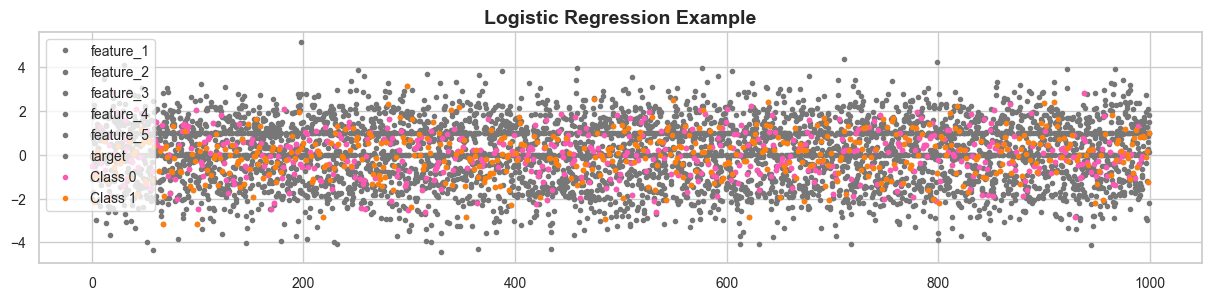

In [4]:
color_pal = ['#ff57b4', '#ff7f0e', '#777777']

df.plot(style='.',
        figsize=(15, 3),
        color=color_pal[2],
        title='Logistic Regression Example')

# Plot class 0
df[df['target'] == 0]['feature_1'].plot(
    style='.', color=color_pal[0], label='Class 0')

# Plot class 1
df[df['target'] == 1]['feature_1'].plot(
    style='.', color=color_pal[1], label='Class 1')

plt.title('Logistic Regression Example')
plt.legend()
plt.show()

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.drop('target', axis=1))

# Create new DataFrame with scaled values and original target
features = df.drop('target', axis=1).columns
df_scaled = pd.DataFrame(X_scaled, columns=features)
df_scaled['target'] = df['target']

### Histograms

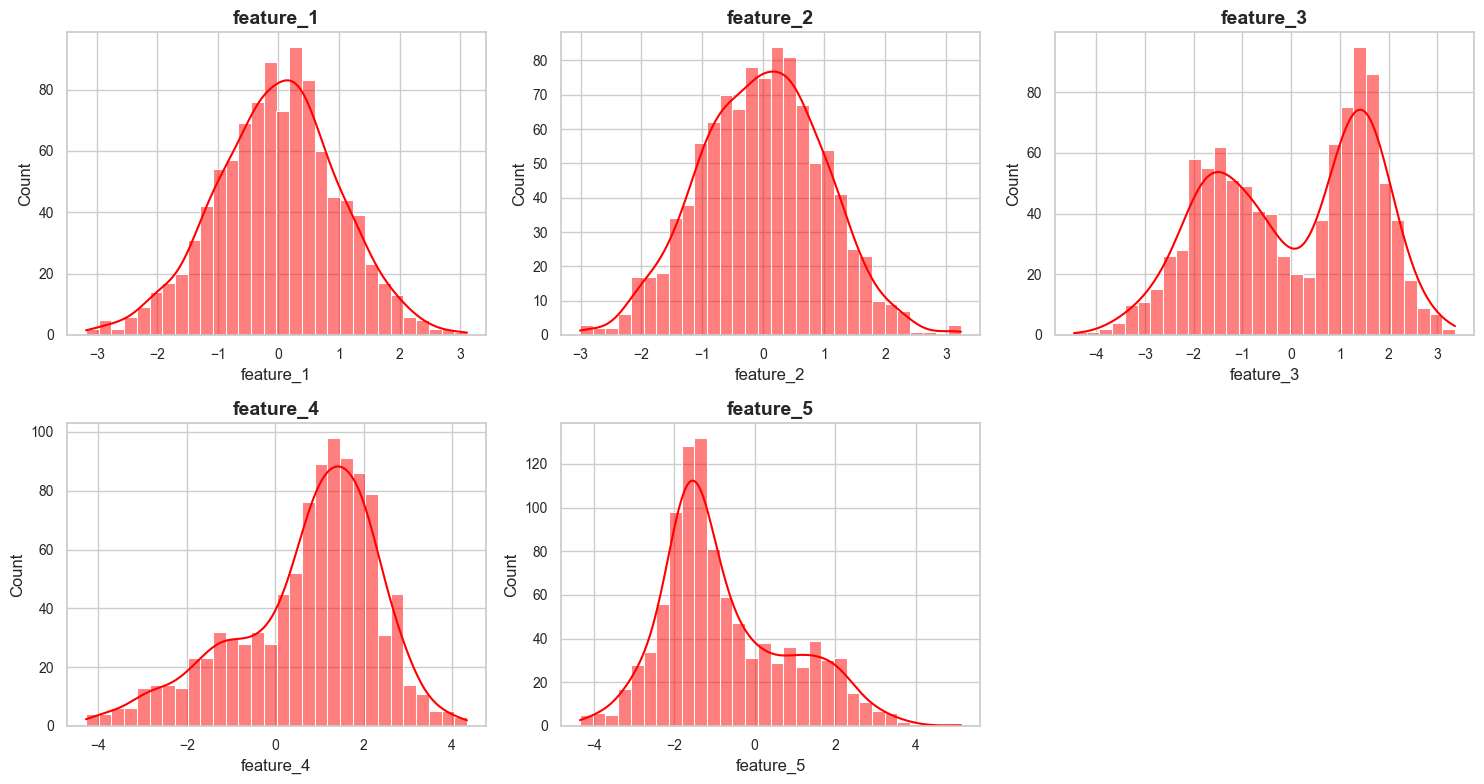

In [6]:
# Plot histograms for train data
features = df.drop('target', axis=1).columns

plt.figure(figsize=(15, 8))
for i, col in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

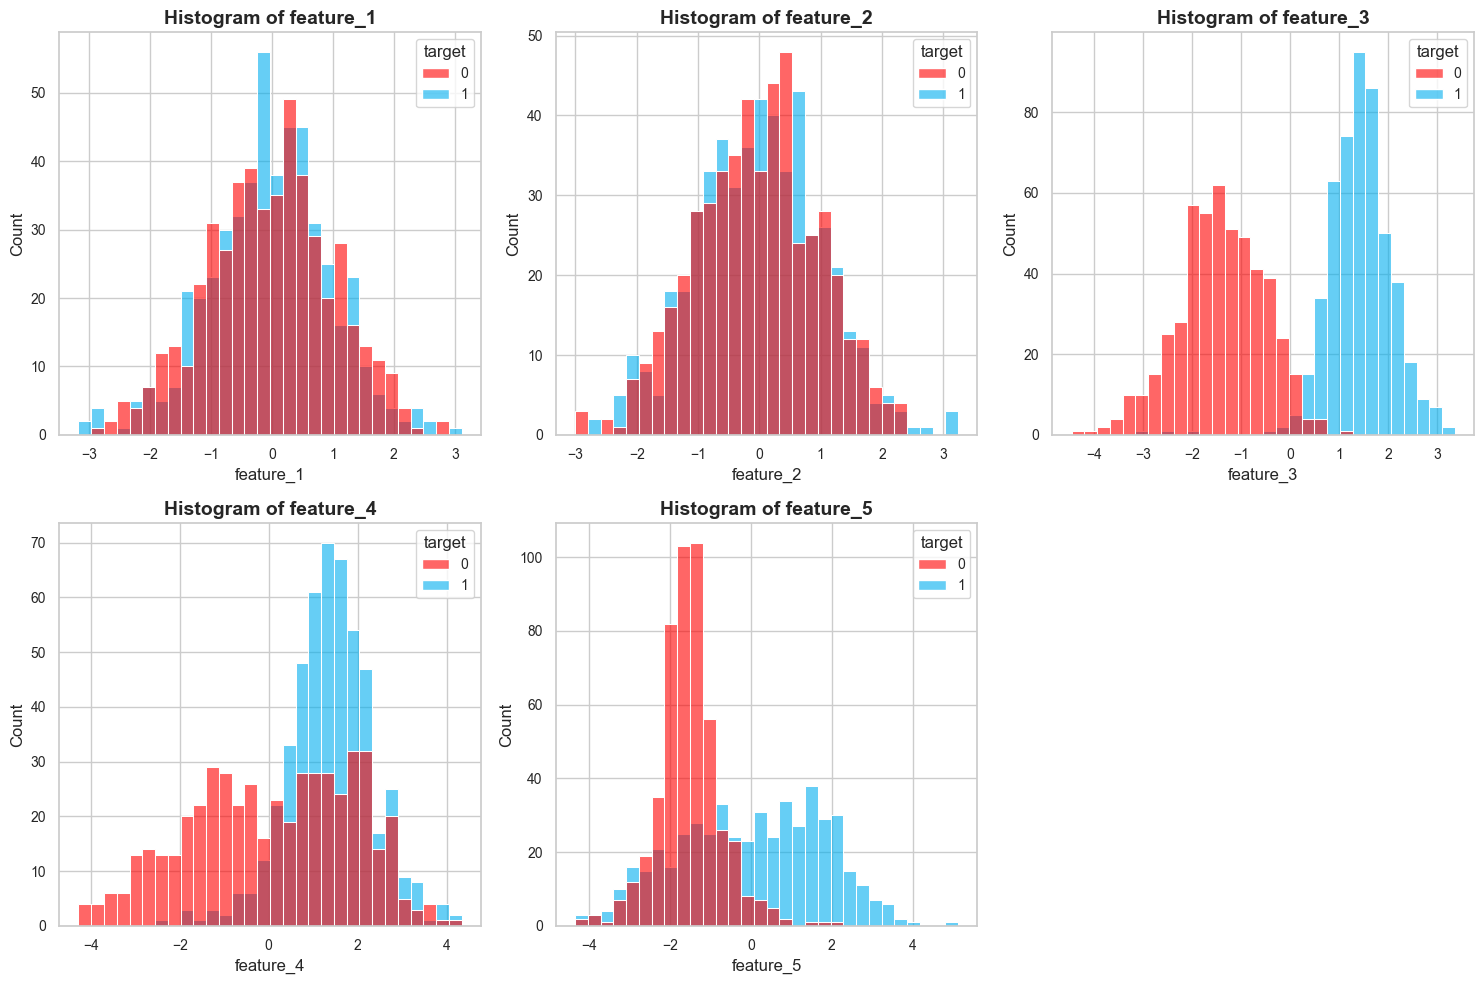

In [7]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.histplot(data=df, x=col, hue='target', bins=30, alpha=0.6)
    plt.title(f'Histogram of {col}')
plt.tight_layout()
plt.show()

### Violinplots

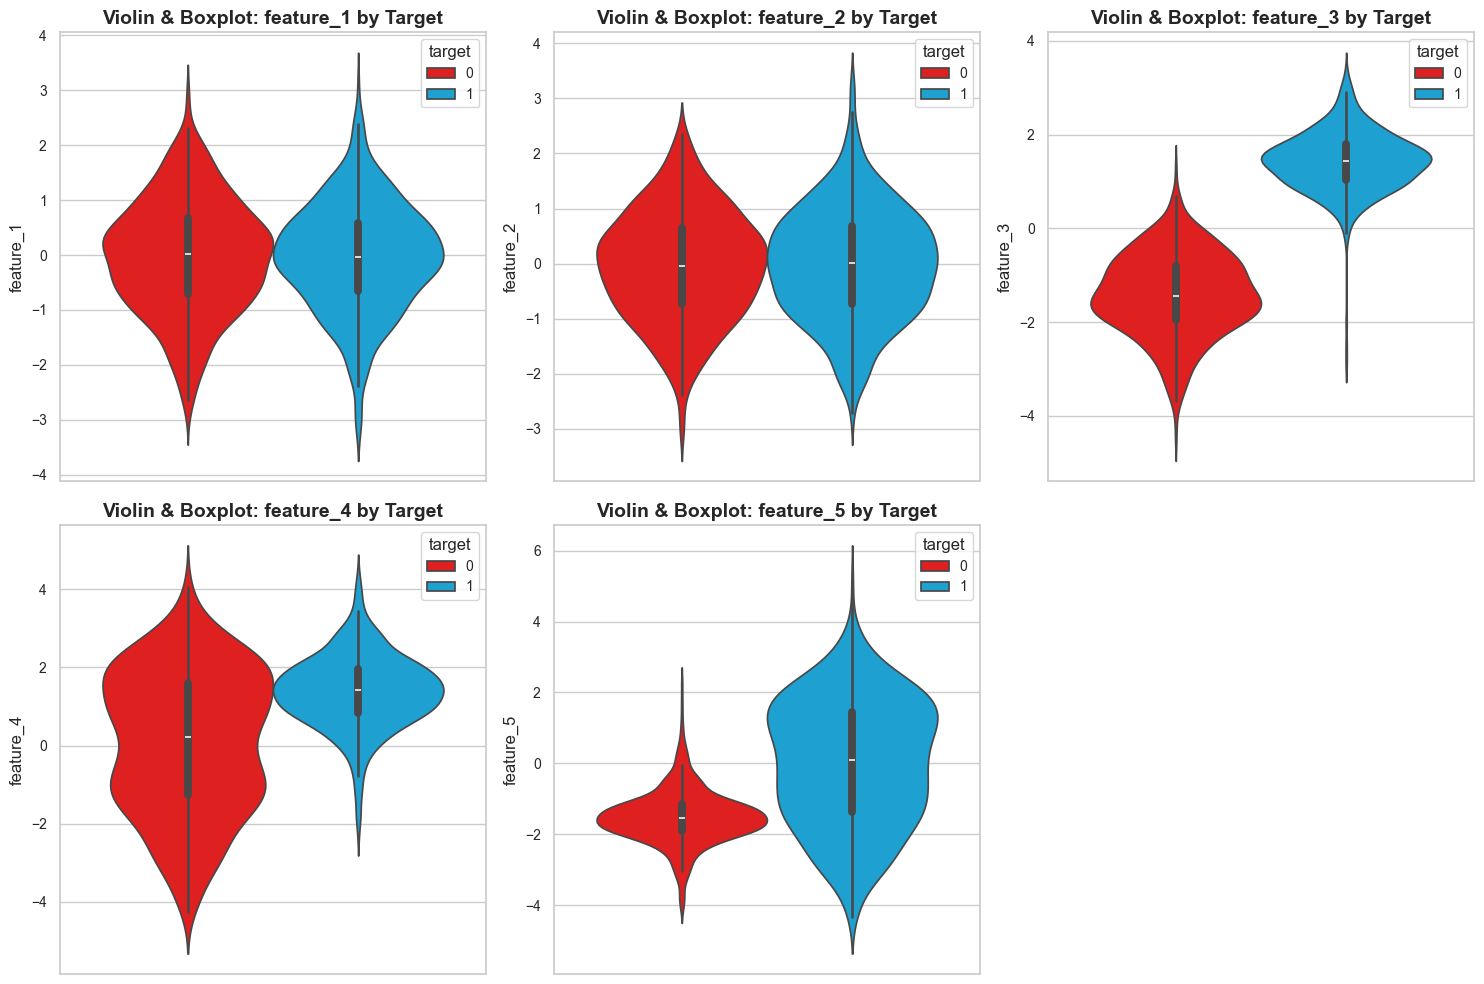

In [8]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.violinplot(data=df, hue='target', y=col, inner='box')
    plt.title(f'Violin & Boxplot: {col} by Target')
plt.tight_layout()
plt.show()

### Boxplots

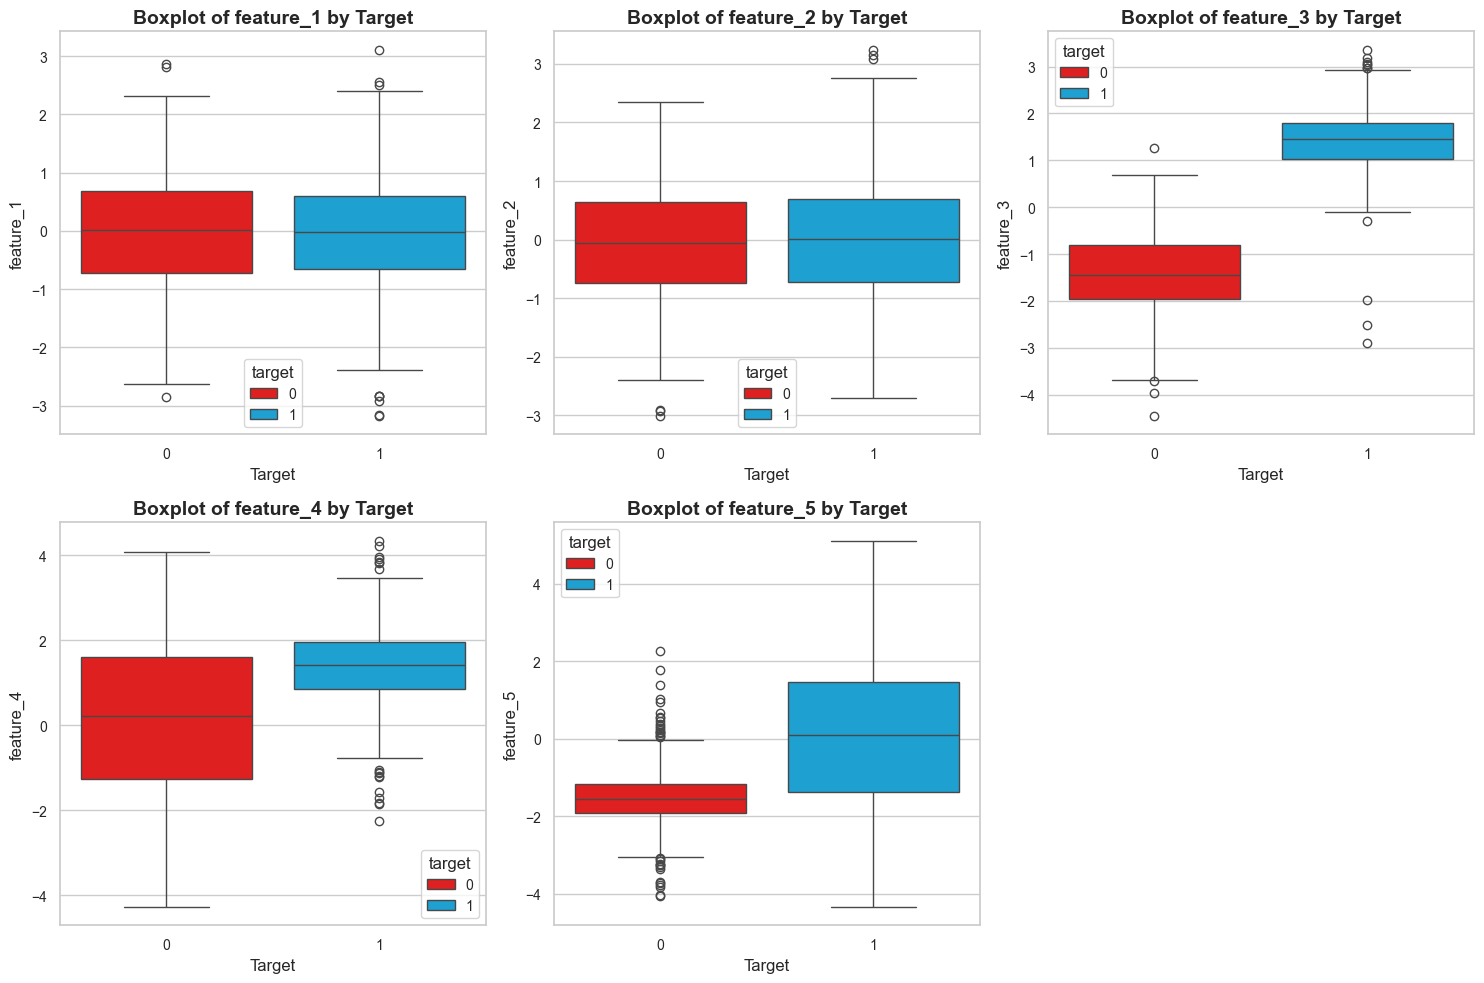

In [9]:
# List of feature column names (excluding the target)
features = df.drop('target', axis=1).columns

# Create boxplots
plt.figure(figsize=(15, 10))
for i, col in enumerate(features, 1):
    plt.subplot(2, 3, i)  # adjust layout based on number of features
    sns.boxplot(data=df, x='target', hue='target', y=col)
    plt.title(f'Boxplot of {col} by Target')
    plt.xlabel('Target')
    plt.ylabel(col)

plt.tight_layout()
plt.show()

## Inspect Outliers

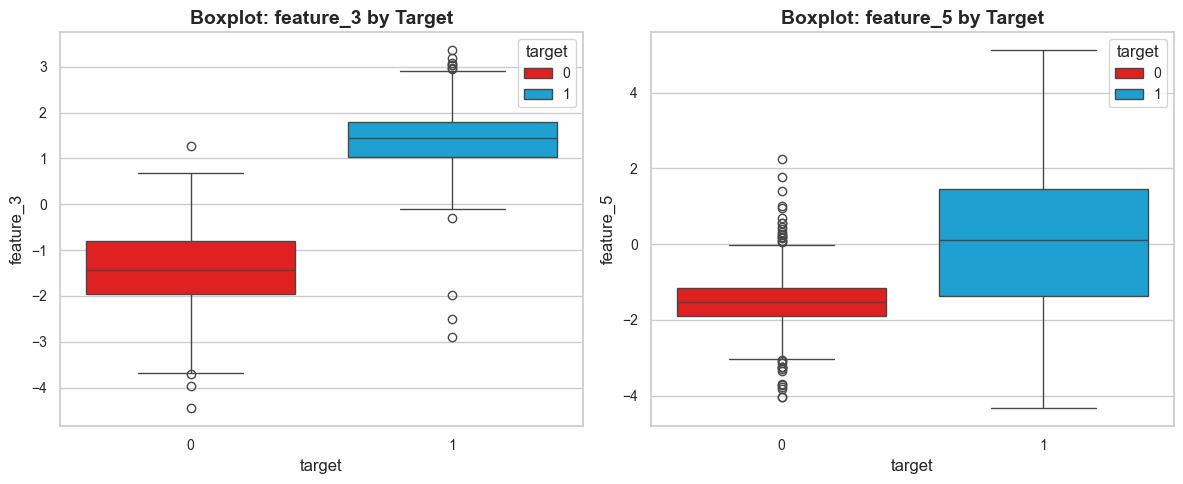

In [10]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(data=df, y='feature_3', x='target', hue='target')
plt.title('Boxplot: feature_3 by Target')

plt.subplot(1, 2, 2)
sns.boxplot(data=df, y='feature_5', x='target', hue='target')
plt.title('Boxplot: feature_5 by Target')

plt.tight_layout()
plt.show()

In [11]:
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR # 1.5 * IQR is a common multiplier for outlier detection
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

# Get outliers
outliers_f3 = detect_outliers_iqr(df, 'feature_3')
outliers_f5 = detect_outliers_iqr(df, 'feature_5')


In [12]:
print("Outliers in feature_3:")
print(outliers_f3[['feature_3', 'target']])

print("\nOutliers in feature_5:")
print(outliers_f5[['feature_5', 'target']])

Outliers in feature_3:
Empty DataFrame
Columns: [feature_3, target]
Index: []

Outliers in feature_5:
     feature_5  target
198   5.119524       1
344   3.310113       1
366   3.620739       1
388   3.829912       1
458   3.411000       1
577   3.959918       1
705   3.395891       1
909   3.300755       1
963   3.275710       1
975   3.417665       1


In [14]:
# Option REMOVE: df with outliers removed
# Find indices of outliers
outlier_indices = set(outliers_f3.index).union(outliers_f5.index)

df_removed = df.drop(index=outlier_indices)

In [24]:
# Option CAP: Use capped version to reduce skew
def cap_outliers_iqr(df, column):
    df = df.copy()  # Make a copy first to avoid modifying original
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    return df

df_capped = df.copy()

df_capped = cap_outliers_iqr(df_capped, 'feature_3')
df_capped = cap_outliers_iqr(df_capped, 'feature_5')

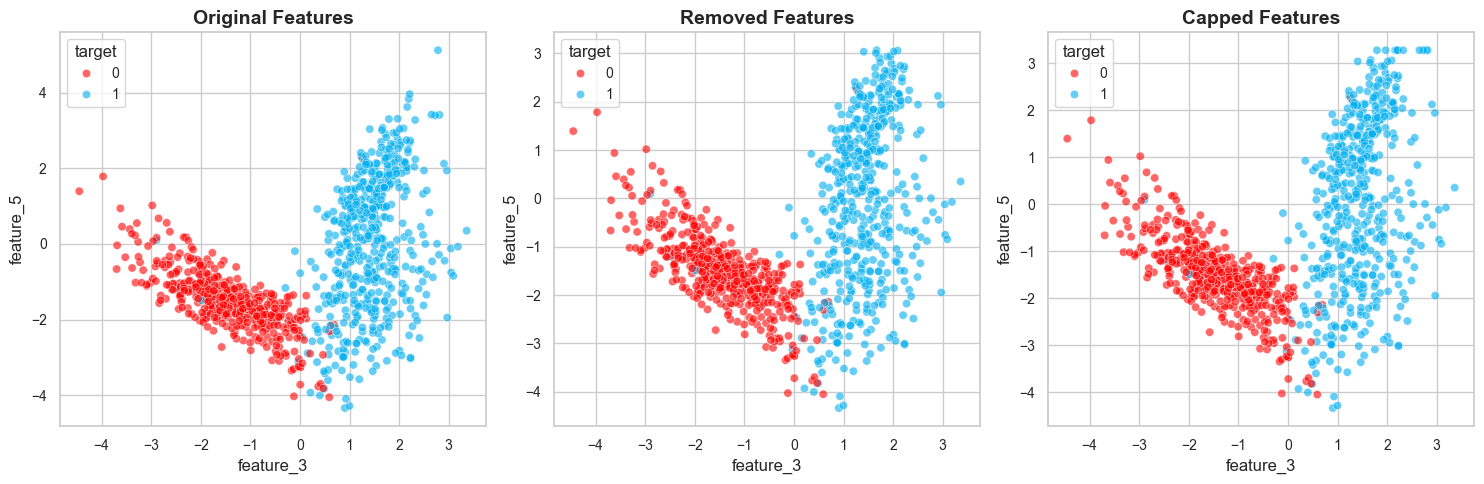

In [23]:
plt.figure(figsize=(15, 5))

# Outliers Removed
plt.subplot(1, 3, 1)
sns.scatterplot(data=df, x='feature_3', y='feature_5', hue='target', alpha=0.6)
plt.title("Original Features")

# Outliers Removed
plt.subplot(1, 3, 2)
sns.scatterplot(data=df_removed, x='feature_3', y='feature_5', hue='target', alpha=0.6)
plt.title("Removed Features")

# Log-transformed
plt.subplot(1, 3, 3)
sns.scatterplot(data=df_capped, x='feature_3', y='feature_5', hue='target', alpha=0.6)
plt.title("Capped Features")

plt.tight_layout()
plt.show()

### Scatterplot

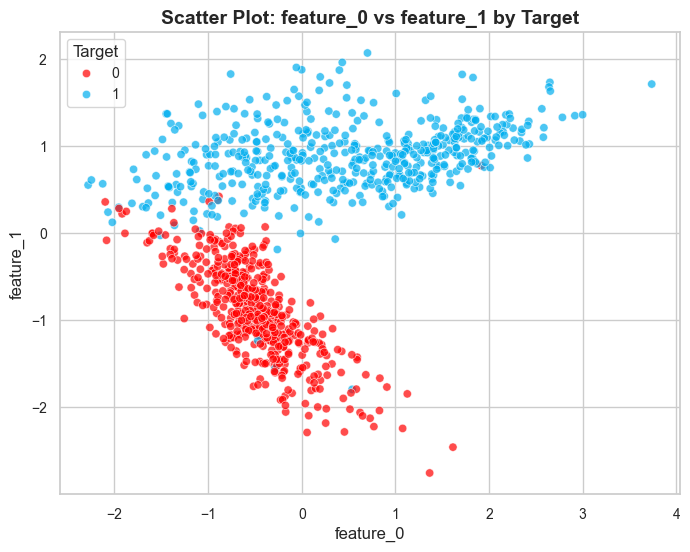

In [25]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_scaled, x='feature_5', y='feature_3', hue='target', alpha=0.7)
plt.title('Scatter Plot: feature_0 vs feature_1 by Target')
plt.xlabel('feature_0')
plt.ylabel('feature_1')
plt.legend(title='Target')
plt.grid(True)
plt.show()

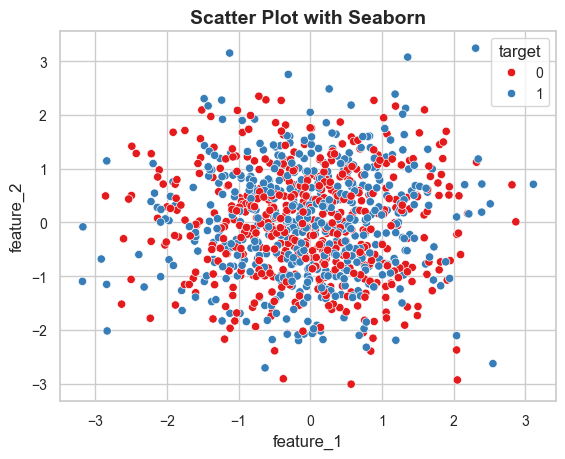

In [26]:
# We plot the relationship between the feature and classes. 
sns.scatterplot(data=df, x='feature_1', y='feature_2', hue='target', palette='Set1')
plt.title('Scatter Plot with Seaborn')
plt.show()

# Step 3: Model Selection & Training

### Train-Test-Split

In [ ]:
X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Logistic Regression

1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        92
           1       1.00      1.00      1.00       108

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



Text(0, 0.5, 'Feature 2')

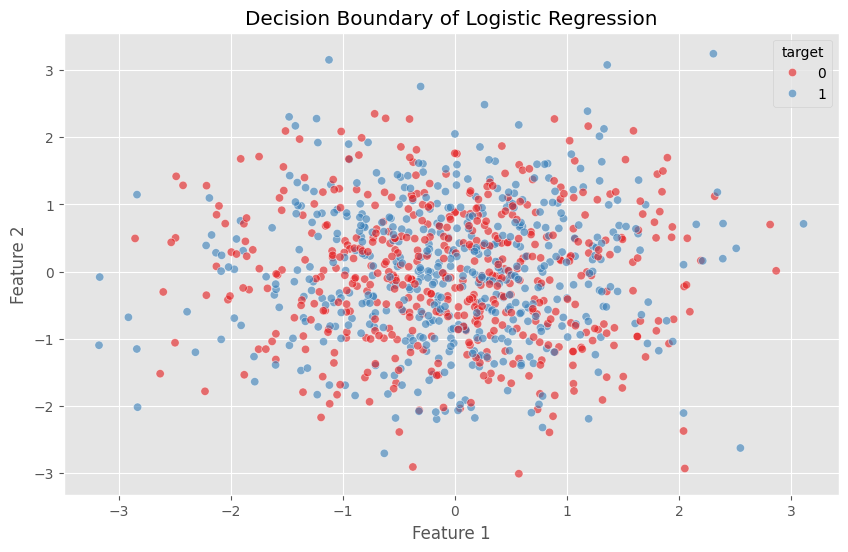

In [ ]:
# Train a logistic regression model
lr = LogisticRegression()
lr.fit(X_train, y_train)

# Evaluate the model
y_pred = lr.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plot the decision boundary
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='feature_1', y='feature_2', hue='target', palette='Set1', alpha=0.6)
plt.title('Decision Boundary of Logistic Regression')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')